## Programa de Pós-Graduação em Ciência da Computação - CEFET/RJ
## Trabalho 2B - Aprendizado de Máquina

#### Aluna: Rebecca Pontes Salles, Professor: Eduardo Bezerra, Data: 31/10/2017

### Introdução

O seguinte relatório apresenta o desenvolvimento do segundo trabalho prático da disciplina de Aprendizado de Máquina do curso de Mestrado em Ciência da Computação do CEFET/RJ. Este trabalho envolveu a implementação de algoritmos de Detecção de Anomalias e de Aprendizagem de Filtragem Colaborativa (2B), utilizando a linguagem Python. Dados foram fornecidos como exemplo para aplicação dos códigos produzidos. O algoritmo de detecção de anomalia foi aplicado para detectar servidores com falha em uma rede, enquanto a filtragem colaborativa foi usada para criar um sistema de recomendação para filmes.

### Trabalho 2B - Parte 1 - Detecção de Anomalias

A primeira parte do trabalho 2B se referia à análise, implementação e prática de um algoritmo de detecção de anomalias utilizando um modelo gaussiano. O objetivo é usar este modelo gaussiano para detectar exemplos anômalos no conjunto de dados ao encontrar valores que têm probabilidade
muito baixa. Para isso, foi utilizado o arquivo __ex8data1.mat__ contendo três colunas de dados relacionados aos comportamentos observados nos servidores de um centro de dados. A primeira e a segunda coluna correspondem a medições de vazão (_throughput_) (mb/s) e de latência (ms) de resposta de cada servidor. A terceira coluna contém os valores da classe (y = 0 significa comportamento normal, e y = 1 significa comportamento anômalo).

#### 1.1 e 1.2 - Distribuição Gaussiana e Estimativa de parâmetros

Como primeira tarefa, para realizar a detecção de anomalia, é preciso ajustar um modelo à distribuição dos dados. Para isso, estima-se a distribuição gaussiana para cada uma das características _xj_, encontrando para cada característica _j = 1,...,n_, os parâmetros _μj_ e _σ²j_ que se encaixam nos dados. Os parâmetros, _(μj,σ²j)_, da j-ésima característica são estimados usando as equações
<img src="mu_sigma.png" alt="mu_sigma" style="width: 300px;"/>.

Para a estimação desses parâmetros foi implementada a função __estimativaGaussian__ no arquivo __estimativaGaussian.py__, que toma como entrada a matriz de dados _X_ e produz um vetor de dimensão _n_ _mu_ que contém a média de todas as características e outro vetor de dimensão _n_ _sigma2_ que contém as variâncias de todas as características. Esta função pode ser vista a seguir.

In [1]:
import numpy as np

def estimativaGaussian(x):
    m = x.shape[0]
    var = x.shape[1]

    mu = []
    sigma2 = []
    for j in range(var):
        mu.append(np.sum(x[:, j]) / float(m))
        sigma2.append(np.sum( np.power( (x[:, j] - mu[j]) ,2) ) / float(m))
    
    return np.array(mu), np.array(sigma2)

De posse dos parâmetros _(μj,σ²j)_, a distribuição gaussiana é dada pela equação
<img src="gaussian_pure.png" alt="gaussian_pure" style="width: 300px;"/>.
que pode ser reescrita como
<img src="gaussian.png" alt="gaussian" style="width: 400px;"/>

A função de probabilidade, com base na distribuição gaussiana, foi implementada na função __probModel__ que utiliza as funções __estimativaGaussian__ (caso os parâmetros não forem fornecidos) e __gaussian__ que implementa o modelo gaussiano em si. Estas funções são apresentadas a seguir.

In [2]:
def gaussian(x,mu,sigma2):
    return 1./(np.sqrt(2*np.pi*sigma2)) * np.exp(-np.power((x - mu), 2)/(2*sigma2))

def probModel(x,mu=None,sigma2=None):
    var = x.shape[1]
    
    #se mu ou sigma2 não fornecidos, estimar
    if mu is None or sigma2 is None:
        mu,sigma2 = estimativaGaussian(x)
    
    p = []
    for j in range(var):
        p.append( gaussian(x[:, j],mu[j],sigma2[j]) )
    
    p = np.prod(p, axis=0)
    
    return p,mu,sigma2

Foi pedida também a implementação de um script em Python para a produção de um _gráfico de dispersão_ para melhor visualização dos dados fornecidos. O script e o gráfico gerado são apresentados a seguir.

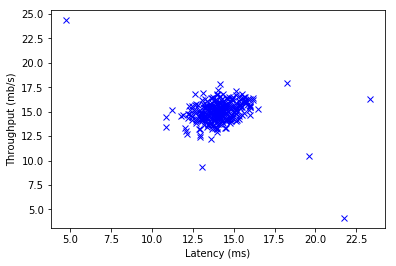

In [5]:
import matplotlib.pyplot as plt
import scipy.io as spio

mat = spio.loadmat('Trabalho 2\ex8data1.mat', squeeze_me=True)

X = mat['X']

p,mu,sigma2 = probModel(X,None,None)

data, = plt.plot(X[:,0], X[:,1], "x", c="blue", label="Data")
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

#### 1.3 - Selecionando ϵ

A próxima tarefa desta parte do trabalho é investigar quais exemplos têm uma probabilidade muito alta dada essa distribuição e quais exemplos têm uma probabilidade muito baixa. Os exemplos de baixa probabilidade são mais prováveis de ser as anomalias no conjunto de dados. Uma maneira de determinar quais exemplos são anomalias é selecionar um limite ϵ com base em um conjunto de validação cruzada. Para isso, foi implementada uma função denominada __selectThreshold__ no arquivo __selectThreshold.py__ que executa um algoritmo para selecionar o limite ϵ usando a medida F1 em um conjunto de validação cruzada.

A função __selectThreshold__ deve retorna dois valores. O primeiro é o limite selecionado ϵ. Se um exemplo _x_ tiver uma baixa probabilidade _Pr(x) < ϵ_, então é considerado uma anomalia. A função também retorna a pontuação _F1_, que indica o quão bem as anomalias verdadeiras estão sendo encontradas, dado um determinado limite. De maneira geral, a função __selectThreshold__ testa muitos valores diferentes de ϵ e seleciona o melhor ϵ com base no resultado _F1_. O código desta função pode ser visto a seguir.

In [6]:
#Entrada:
#prXval: probabilidades dos exemplos de validação
#yval: os rótulos de cada exemplo de validação
def selectThreshold(prXval,yval):
    epsilon = 0
    f1 = 0
    
    step = (prXval.max() - prXval.min()) / 1000
    
    #para cada ϵ analisado
    for curr_e in np.arange(prXval.min(), prXval.max(), step):
        tp,fp,fn = 0.0,0.0,0.0
        for i in range(prXval.shape[0]):
            pred = prXval[i] < curr_e
            y = yval[i]
            #soma verdadeiros positivos
            tp = tp+1 if pred == 1 and y == 1 else tp
            #soma falsos positivos
            fp = fp+1 if pred == 1 and y == 0 else fp
            #soma falsos negativos
            fn = fn+1 if pred == 0 and y == 1 else fn
        
        #medida de precisão
        prec = 0 if tp == 0 else tp/(tp + fp)
        #medida de revocação
        rec = 0 if tp == 0 else tp/(tp + fn)
        #medida de F1 para o ϵ atual (curr_e)
        curr_f1 = 0 if prec+rec == 0 else (2*prec*rec)/(prec+rec)
        
        if curr_f1 > f1:
            f1 = curr_f1
            epsilon = curr_e
    
    return epsilon, f1

A corretude das funções produzidas foi confirmada com a aplicação vista a seguir onde podemos ver um ϵ selecionado de cerca de 8.99e-05 e também os pontos anômalos do conjunto de dados marcados em vermelho no gráfico gerado.

Selected threshold: 8.99085277927e-05, F1: 0.875


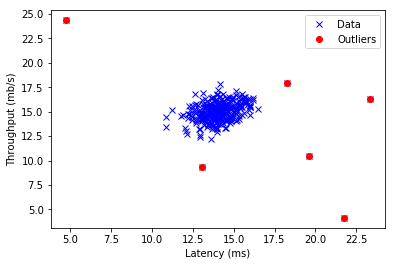

In [7]:
Xval = mat['Xval']  
yval = mat['yval']

#probabilidades do conjunto de treinamento e cálculo de parâmetros
p,mu,sigma2 = probModel(X,None,None)

#probabilidades do conjunto de validação cruzada com parâmetros aprendidos 
prXval = probModel(Xval,mu,sigma2)[0]

#seleção do melhor ϵ
epsilon, f1 = selectThreshold(prXval,yval)
print 'Selected threshold: ' + str(epsilon) + ', F1: ' + str(f1)

#índices dos exemplos anômalos
outls = np.where(p < epsilon)[0]

#plota dados
data, = plt.plot(X[:,0], X[:,1], "x", c="blue", label="Data")
outliers, = plt.plot(X[outls,0], X[outls,1], "o", c="red", label="Outliers")
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.legend(loc='upper right')
plt.show()

### Trabalho 2B - Parte 2 - Sistemas de Recomendação

A segunda parte do trabalho se refere à implementação e aplicação do algoritmo de aprendizagem de filtragem colaborativa a um conjunto de dados de avaliações de filmes. Para isso, foi utilizado o arquivo __ex8_movies.mat__ que contém a matriz _Y_ (de ordem _número de filmes x número de usuários_) que armazena as classicações _y(i,j)_ (de 1 a 5), e a matriz _R_ que é uma matriz de indicadores de valor binário, onde _R(i,j)_ = 1 se o usuário _j_ forneceu uma classificação para o filme i e _R(i,j)_ = 0 em caso contrário. O objetivo da filtragem colaborativa é prever as classificações de filmes para os filmes que os usuários ainda não classificaram, ou seja, as entradas com _R(i,j)_ = 0. Isso permite recomendar os filmes com classificacões mais altas previstas para outros usuários.

Também foi necessário trabalhar com as matrizes, _X_ e _Theta_. Essas matrizes se encontram no arquivo __ex8_movieParams.mat__. A i-ésima linha de _X_ corresponde ao vetor de característica _x(i)_ para o i-ésimo filme, enquanto a j-ésima linha de _Theta_ corresponde a um vetor de parâmetros θ(j), para o j-ésimo usuário.

#### 2.2 - Função de custo e gradiente da filtragem colaborativa

Em seguida a tarefa definida foi implementar o código para calcular a função de custo e o gradiente para a filtragem colaborativa (sem regularização).

Para isso foi criada uma função em Python denominada __cofiCostFunc__ no arquivo __cofiCostFunc.py__, que computa o custo e o gradiente para a filtragem colaborativa, onde os parâmetros para a função (ou seja, os valores que tentamos aprender) devem ser _X_ e _Theta_. A função implementa a seguinte equação
<img src="custoFiCo.png" alt="custoFiCo" style="width: 550px;"/>
tendo como entrada o vetor de parâmetros _params_, a matriz _Y_, a matrix _R_ e o número de características consideradas pelo algoritmo _nFeatures_. A função __cofiCostFunc__ retorna o valor da função de custo da filtragem colaborativa com parâmetros _X_ e _Theta_, assim como os seus gradientes (em um único vetor), ou seja,
<img src="gradFiCo.png" alt="gradFiCo" style="width: 300px;"/>.
Foi criada também neste arquivo uma função auxiliar __htheta__ para cumputar o valor de
<img src="hFiCo.png" alt="hFiCo" style="width: 100px;"/>.
Os códigos destas funções podem ser vistos a seguir.

In [8]:
def cofiCostFunc(params, Y, R, nFeatures):
    Y = np.matrix(Y)
    R = np.matrix(R)
    nm = Y.shape[0] #número de filmes
    nu = Y.shape[1] #número de usuários
    
    #formata X e Theta com base em params
    X = np.matrix(np.reshape(params[:(nm*nFeatures)], (nm, nFeatures))) #(número de filmes x número de características)
    Theta = np.matrix(np.reshape(params[(nm*nFeatures):], (nu, nFeatures))) #(número de usuários x número de características)
    
    #computa erro
    error = np.multiply(htheta(X,Theta) - Y, R) #(número de filmes x número de usuários)
    #computa custo J
    J = np.sum( np.power( error , 2) ) / (2.0)
    
    #computa gradiente de X
    X_grad = np.dot(error,Theta)
    #computa gradiente de Theta
    Theta_grad = np.dot(error.T,X)
    
    #transforma gradientes em um único vetor
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

def htheta(X,Theta):
    return np.dot(X, Theta.T)

A corretude destas funções foi verificada executando-as com os parâmetros _X_ e _Theta_ pré-treinados contidos em __ex8_movieParams.mat__. Além disso, para diminuir o custo computacional do teste foi selecionado um subconjunto dos dados definindo o número de filmes igual a 5, o número de usuários igual a 4 e o número de carcterísticas igual a 3. Assim como esperado, a função __cofiCostFunc__ gerou aproximadamente o valor 22.22 para a função de custo da filtragem colaborativa.

In [10]:
#carrega dados de Y e R
mat = spio.loadmat('Trabalho 2\ex8_movies.mat', squeeze_me=True)
Y = mat['Y']
R = mat['R']

#carrega dados de X e Theta já otimizados
params_data = spio.loadmat('Trabalho 2\ex8_movieParams.mat', squeeze_me=True)  
X = params_data['X']  
Theta = params_data['Theta']

#define número de usuários, filmes e características consideradas
users = 4  
movies = 5  
features = 3

#seleciona subconjunto de dados
X_sub = X[:movies, :features]  
Theta_sub = Theta[:users, :features]  
Y_sub = Y[:movies, :users]  
R_sub = R[:movies, :users]

#concatena X e Theta iniciais em um único vetor
params = np.concatenate((np.ravel(X_sub), np.ravel(Theta_sub)))

#computa custo
J, grad = cofiCostFunc(params, Y_sub, R_sub, features)  
print "Custo: " + str(J) + "\nGradiente: " + str(grad)

Custo: 22.2246037257
Gradiente: [ -2.52899165   7.57570308  -1.89979026  -0.56819597   3.35265031
  -0.52339845  -0.83240713   4.91163297  -0.76677878  -0.38358278
   2.26333698  -0.35334048  -0.80378006   4.74271842  -0.74040871
 -10.5680202    4.62776019  -7.16004443  -3.05099006   1.16441367
  -3.47410789   0.           0.           0.           0.           0.           0.        ]
